`密度推定器` D次元のデータ・セットから、そのデータが引き出されるD次元確率分布の推定値を生成するアルゴリズム

`カーネル密度推定(KDE: Kernel Density Estimation)` ポイントごとに1つのガウス分布を重ね合わせることで、本質的にノンパラメトリックの密度推定を行う

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## 5.13.1 KDEの必要性：ヒストグラム

In [3]:
#2つの正規分布から出られるデータを作成
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x
x = make_data(1000)

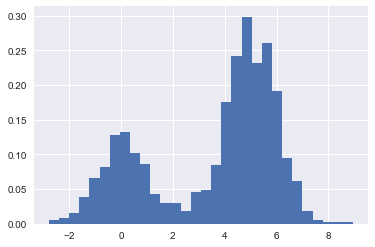

In [4]:
hist = plt.hist(x, bins=30, normed=True)

In [5]:
#均等ビンの場合、この正規化は単にy軸のスケールを変更するだけで、相対的な高さは個数から作成されたヒストグラムと本質的に同じ
#ヒストグラムの総面積が1になることを確認
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [6]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

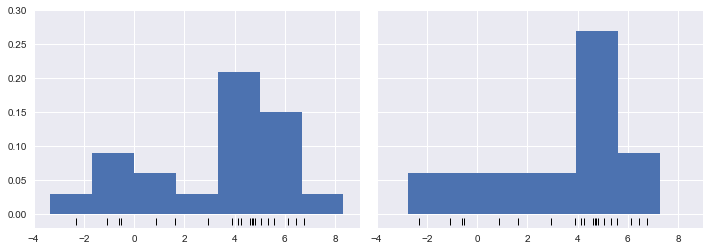

In [7]:
#ビンの選択方法を変えると全く異なるデータに見える
fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True, subplot_kw={'xlim':(-4, 9), 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, normed=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)


(-0.2, 8)

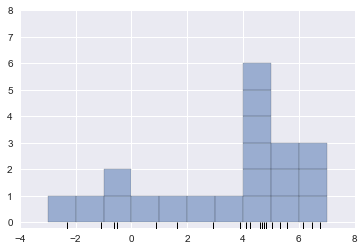

In [8]:
#ブロックの積み重ねとしてのヒストグラム
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
        markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                   alpha=0.5, edgecolor='black'))
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

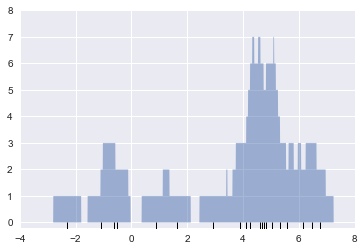

In [9]:
#x軸に沿ったそれぞれの位置に、寄与分のポイントを配置
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

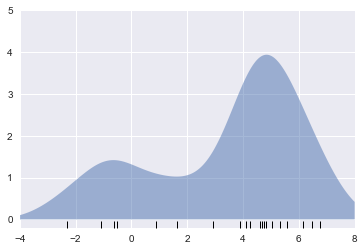

In [10]:
#各位置のブロックをガウス関数のような滑らかな関数に置き換える
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

## 5.31.2 カーネル密度推定の実線

(-0.02, 0.22)

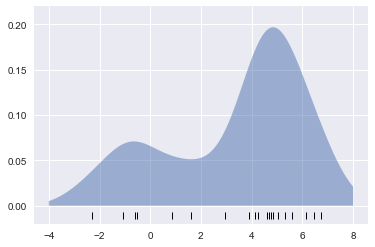

In [11]:
from sklearn.neighbors import KernelDensity

#KDEモデルをインスタンス化して当てはめを行う
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

#score_samplesは確率密度の対数を返す
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

### 5.13.2.1 交差検証によるバンド幅の選択

`バンド幅`各点におけるカーネルのサイズを制御する。密度推定におけるバイアスとバリアンスのトレードオフを制御する

- バンド幅が狭すぎるとバリアンスが大きくなり（過剰適合）、1つの点のある無しで大きな違いが生じる
- バンド幅が広すぎるとバイアスが大きくなり（適合不足）、データ内の構造が反映されなくなる

In [12]:
#GridSearchCV(): データセットのバンド幅を最適化する
#交差検証の試行ごとに学習セットのデータセットが小さくなりすぎないように、leave-one-out交差検証を使用する
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut(len(x)))
grid.fit(x[:, None]);

/Users/shoki/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/shoki/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [13]:
#スコアを最大にするバンド幅を見つける
grid.best_params_

{'bandwidth': 1.1233240329780276}

### 5.13.3 事例：球面上のKDE

In [14]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and locations
latlon = np.vstack([data.train['dd lat'],
                    data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

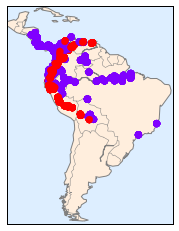

In [16]:
#2つの種が観察された位置を南米の地図上にプロットする
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
          c=species, cmap='rainbow', latlon=True);

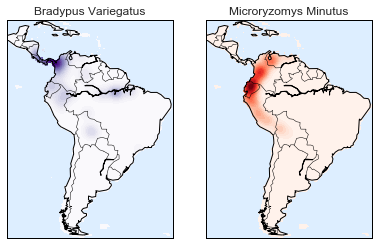

In [18]:
#地図のデータグリッドを設定する
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

#2つの横並びの図を作成する
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # Basemapを使って海岸線を描く
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    #分布の球面状核密度推定を作成する
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))

    #陸上でのみ評価を行う。-9999は海を示す
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)

    # 密度の分布を描く
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

### 5.13.4 事例：単純ではないベイズ推定

1. 学習データをラベルで分割する

2. 各データセットに対して、データの生成モデルを得るためにKDEを当てはめる
   これにより、任意の観測$x$とラベル$y$に対するクラスの尤度$P(x~|~y)$を計算できる
   
3. 学習データセット内に存在する各クラスのデータの数から、事前確率$P(y)$を計算する。

4. 未知の点$x$については、各クラスの事後確率は$P(y~|~x) \propto P(x~|~y)P(y)$となる。
   ポイントに割り当てられたラベルが、この事後確率を最大化するクラスとなる

In [19]:
from sklearn.base import BaseEstimator, ClassifierMixin


class KDEClassifier(BaseEstimator, ClassifierMixin):
    """　KDEベースの生成的ベイズ分類器
    
    Parameters
    ----------
    bandwidth : float
        各クラスのカーネルバンド幅
    kernel : str
        KernelDensityにわたすカーネルの名前
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
        
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

### 5.13.4.1 カスタム推定機の解説

```python
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """　KDEベースの生成的ベイズ分類器
    
    Parameters
    ----------
    bandwidth : float
        各クラスのカーネルバンド幅
    kernel : str
        KernelDensityにわたすカーネルの名前
    """
```

BaseEstimatorクラスと標準の機能を提供する適切なmixinから継承させる
- BaseEstimator: 交差検証で使用するために推定器を複製するのに必要なロジックを持つ
- ClassifierMixin: そうした関数が使用するデフォルトのscore()メソッドを定義

```python
def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
```

オブジェクトがKDEClassifier()でインスタンス化されたときに最初に実行されるコード

```python
def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        return self
```

学習データ内でのユニークなクラスを見つけ出し、各クラスに対するKernelDensityモデルの学習を行い、入力サンプルの数に基づいてクラスの事前確率を計算する

```python
def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
        
def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]
    
```

新しいデータに対してラベルを推定するロジックを記載する。predict_probaはクラス確率配列を返す。predictはこの結果を使用して最も確率が高いクラスを返す

### 5.13.4.2 カスタム推定器の使用

In [22]:
from sklearn.datasets import load_digits
from sklearn.grid_search import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


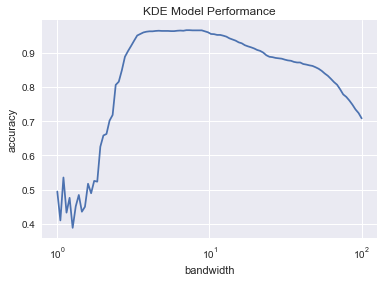

In [24]:
#交差検証スコアをバンド幅の関数としてプロットする
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)